In [1]:
import torch
import matplotlib.pyplot as plt
plt.rc('font', size=16)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 1. Data

In [3]:
import torch.nn as nn
from torchvision import datasets, transforms

In [4]:
fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transforms.ToTensor(), download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transforms.ToTensor(), download=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
fmnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../../../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
fmnist_test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../../../data
    Split: Test
    StandardTransform
Transform: ToTensor()

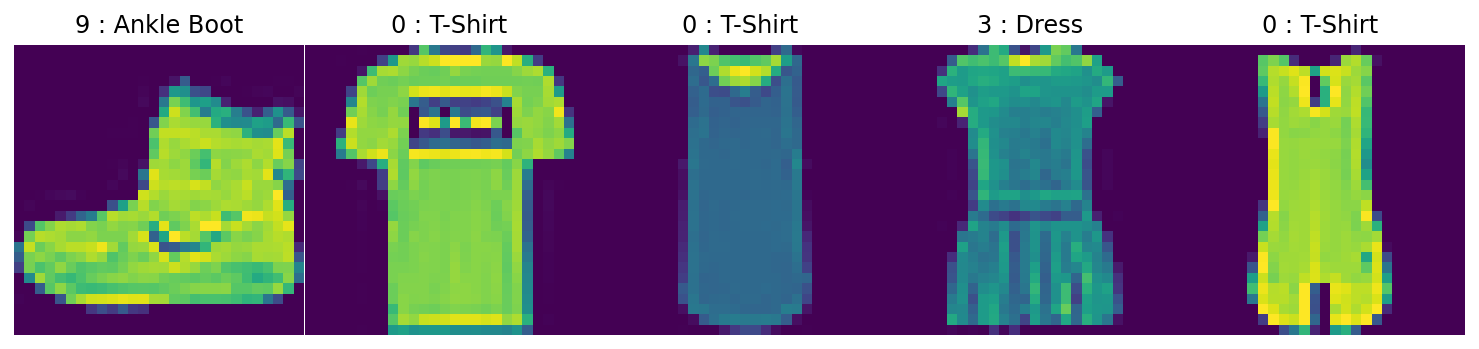

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
plt.subplots_adjust(hspace=0.001, wspace=0.001)

for i in range(5):
    image, label = fmnist_train.__getitem__(i)
    axes[i].imshow(image.squeeze().numpy())
    axes[i].set_title(f'{label} : {labels_map[label]}')
    axes[i].axis('off')

## 1.2 DataLoader

In [8]:
from torch.utils.data import DataLoader

In [9]:
batch_size = 100

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

In [10]:
# Iterate through DataLoader
train_images, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_images.shape}")
print(f"Labels batch shape: {train_labels.shape}")

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


In [11]:
print('Number of iterations per epoch', len(train_loader)) # 60000 // batch_size + 1

Number of iterations per epoch 600


# 2. Model

### [torch.nn](https://pytorch.org/tutorials/beginner/nn_tutorial.html) modules -- a base class used to develop all neural network models

In [12]:
import torch.nn as nn

In [13]:
input_size = 28*28
output_size = 10
hidden1_size = 256
hidden2_size = 256

p1 = 0.2 # dropout p for hidden layer 1
p2 = 0.5 # dropout p for hidden layer 2

## --- Model 1 (d2l §4.6) -------------------------
## ------ MLP (3 layer network) without dropout --- 
## ------------------------------------------------

class MLP(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super().__init__()        
        self.lin1 = nn.Linear(input_size, hidden1_size)        
        self.lin2 = nn.Linear(hidden1_size, hidden2_size)
        self.lin3 = nn.Linear(hidden2_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, X):            
        H1  = self.relu(self.lin1(X))
        H2  = self.relu(self.lin2(H1))
        out = self.lin3(H2) 
        return out

## --- Model 2 (d2l §4.6) -------------------------
## ------ MLP with dropout ------------------------ 
## ------------------------------------------------

class MLP_dropout(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, p1, p2):
        super().__init__()        
        self.lin1 = nn.Linear(input_size, hidden1_size)        
        self.lin2 = nn.Linear(hidden1_size, hidden2_size)
        self.lin3 = nn.Linear(hidden2_size, output_size)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p1)
        self.dropout2 = nn.Dropout(p2)
        
    def forward(self, X):            
        H1  = self.relu(self.lin1(X))
        H1  = self.dropout1(H1)
        H2  = self.relu(self.lin2(H1))
        H2  = self.dropout2(H1)
        out = self.lin3(H2) 
        return out

In [14]:
# model original
model_ori = MLP(input_size, hidden1_size, hidden2_size, output_size)
model_ori.to(device)

# model with dropout
model_dropout = MLP_dropout(input_size, hidden1_size, hidden2_size, output_size, p1, p2)
model_dropout.to(device)

# model with L2 regularization
model_L2 = MLP(input_size, hidden1_size, hidden2_size, output_size)
model_L2.to(device)

MLP(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

In [15]:
# count model parameters
print('TOTAL  :', sum(param.numel() for param in model_ori.parameters() if param.requires_grad))

TOTAL  : 269322


# 3. Loss

In [16]:
criterion = nn.CrossEntropyLoss()

Usage : `loss = criterion(Y_pred, Y)`

**Careful!** <br>
`nn.CrossEntropyLoss` applies: ``nn.LogSoftmax`` and ``nn.NLLLoss`` (negative log likelihood loss). <br>
So don't apply softmax in the forward loop. <br>
``Y`` is class (digit) labels, not one-hot!   <br>
``Y_pred`` has raw scores (logits), no Softmax!

# 4. Optimization

In [17]:
import torch.optim as optim

In [18]:
learning_rate = 0.1
weight_decay = 0.001

optimizer_ori = torch.optim.SGD(model_ori.parameters(), lr=learning_rate)
optimizer_dropout = torch.optim.SGD(model_dropout.parameters(), lr=learning_rate)
optimizer_L2 = torch.optim.SGD(model_L2.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 5. Training Loop

### loss.backward() : calculate dloss/dw_i 

### optimizer.step()  : update network parameters (w_i)

### optimizer.zero_grad() 
Whenever `loss.backward()` is called, it'll write the gradients and accumulate them in the w_i.grad attribute. <br>
e.g. try to print out `model.linear1.weight.grad` <br>
So we need to call `optimizer.zero_grad()` to zero gradient again and again for every iteration.

In [19]:
def train_1_epoch(model, optimizer, train_loss, train_acc):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        # reshape images (100, 1, 28, 28) -> (100, 784)
        images = images.reshape(-1, 28*28).to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
            
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

### Train model without any regularization techniques

In [20]:
train_loss_ori = []
train_acc_ori = []
valid_loss_ori = []
valid_acc_ori = []

num_epochs = 60
for epoch in range(0, num_epochs):
    train_1_epoch(model_ori, optimizer_ori, train_loss_ori, train_acc_ori)
    validation(model_ori, valid_loss_ori, valid_acc_ori)

>>> End epoch 1, train accuracy = 73.58%, train avgLoss = 0.7486
>>>              valid accuracy = 78.52%, valid avgLoss = 0.5689
>>> End epoch 2, train accuracy = 83.27%, train avgLoss = 0.4651
>>>              valid accuracy = 83.76%, valid avgLoss = 0.4572
>>> End epoch 3, train accuracy = 85.01%, train avgLoss = 0.4112
>>>              valid accuracy = 84.80%, valid avgLoss = 0.4210
>>> End epoch 4, train accuracy = 86.25%, train avgLoss = 0.3750
>>>              valid accuracy = 85.12%, valid avgLoss = 0.4003
>>> End epoch 5, train accuracy = 87.18%, train avgLoss = 0.3530
>>>              valid accuracy = 86.13%, valid avgLoss = 0.3850
>>> End epoch 6, train accuracy = 87.78%, train avgLoss = 0.3366
>>>              valid accuracy = 85.66%, valid avgLoss = 0.3833
>>> End epoch 7, train accuracy = 88.11%, train avgLoss = 0.3193
>>>              valid accuracy = 87.10%, valid avgLoss = 0.3587
>>> End epoch 8, train accuracy = 88.61%, train avgLoss = 0.3089
>>>              valid ac

### Train model with dropout

In [21]:
train_loss_dropout = []
train_acc_dropout = []
valid_loss_dropout = []
valid_acc_dropout = []

num_epochs = 60
for epoch in range(0, num_epochs):
    train_1_epoch(model_dropout, optimizer_dropout, train_loss_dropout, train_acc_dropout)
    validation(model_dropout, valid_loss_dropout, valid_acc_dropout)

>>> End epoch 1, train accuracy = 73.11%, train avgLoss = 0.7659
>>>              valid accuracy = 80.96%, valid avgLoss = 0.5260
>>> End epoch 2, train accuracy = 81.43%, train avgLoss = 0.5261
>>>              valid accuracy = 83.33%, valid avgLoss = 0.4685
>>> End epoch 3, train accuracy = 82.99%, train avgLoss = 0.4778
>>>              valid accuracy = 84.23%, valid avgLoss = 0.4376
>>> End epoch 4, train accuracy = 83.90%, train avgLoss = 0.4491
>>>              valid accuracy = 84.38%, valid avgLoss = 0.4296
>>> End epoch 5, train accuracy = 84.25%, train avgLoss = 0.4338
>>>              valid accuracy = 84.89%, valid avgLoss = 0.4142
>>> End epoch 6, train accuracy = 85.08%, train avgLoss = 0.4172
>>>              valid accuracy = 84.70%, valid avgLoss = 0.4119
>>> End epoch 7, train accuracy = 85.46%, train avgLoss = 0.4080
>>>              valid accuracy = 85.81%, valid avgLoss = 0.3903
>>> End epoch 8, train accuracy = 85.77%, train avgLoss = 0.3981
>>>              valid ac

### Train model with L2 Regularization

In [22]:
train_loss_L2 = []
train_acc_L2 = []
valid_loss_L2 = []
valid_acc_L2 = []

num_epochs = 60
for epoch in range(0, num_epochs):
    train_1_epoch(model_L2, optimizer_L2, train_loss_L2, train_acc_L2)
    validation(model_L2, valid_loss_L2, valid_acc_L2)

>>> End epoch 1, train accuracy = 73.40%, train avgLoss = 0.7555
>>>              valid accuracy = 80.46%, valid avgLoss = 0.5321
>>> End epoch 2, train accuracy = 82.86%, train avgLoss = 0.4758
>>>              valid accuracy = 83.64%, valid avgLoss = 0.4566
>>> End epoch 3, train accuracy = 84.90%, train avgLoss = 0.4194
>>>              valid accuracy = 84.69%, valid avgLoss = 0.4260
>>> End epoch 4, train accuracy = 85.68%, train avgLoss = 0.3924
>>>              valid accuracy = 84.93%, valid avgLoss = 0.4135
>>> End epoch 5, train accuracy = 86.60%, train avgLoss = 0.3704
>>>              valid accuracy = 84.76%, valid avgLoss = 0.4172
>>> End epoch 6, train accuracy = 86.93%, train avgLoss = 0.3559
>>>              valid accuracy = 85.85%, valid avgLoss = 0.3949
>>> End epoch 7, train accuracy = 87.51%, train avgLoss = 0.3423
>>>              valid accuracy = 85.74%, valid avgLoss = 0.3936
>>> End epoch 8, train accuracy = 87.78%, train avgLoss = 0.3339
>>>              valid ac

# Plots

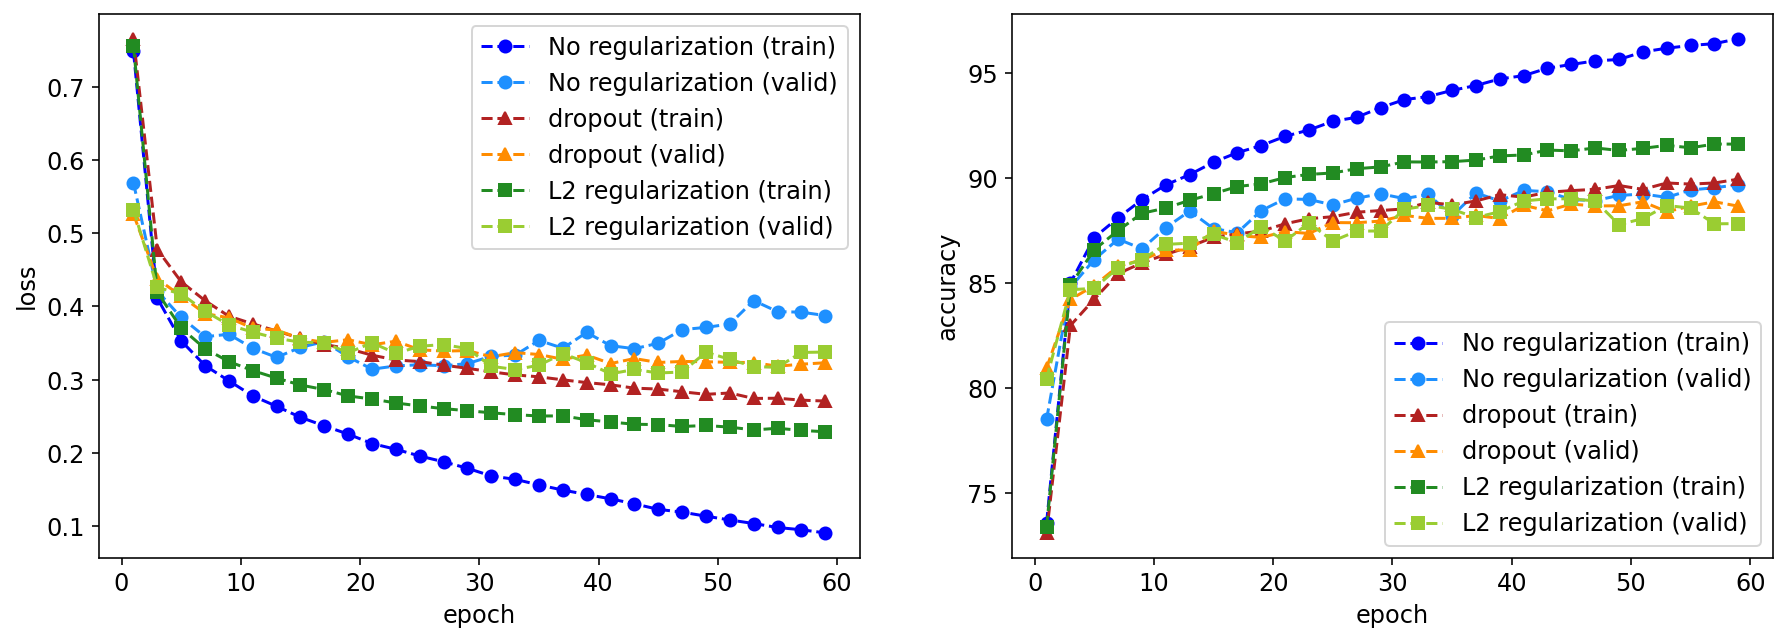

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=12)

ax[0].plot(range(1,num_epochs+1)[::2], train_loss_ori[::2], 'o--', label='No regularization (train)', color='b')
ax[0].plot(range(1,num_epochs+1)[::2], valid_loss_ori[::2], 'o--', label='No regularization (valid)', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::2], train_acc_ori[::2] , 'o--', label='No regularization (train)', color='b')
ax[1].plot(range(1,num_epochs+1)[::2], valid_acc_ori[::2], 'o--', label='No regularization (valid)', color='dodgerblue')

ax[0].plot(range(1,num_epochs+1)[::2], train_loss_dropout[::2], '^--', label='dropout (train)', color='firebrick')
ax[0].plot(range(1,num_epochs+1)[::2], valid_loss_dropout[::2], '^--', label='dropout (valid)', color='darkorange')
ax[1].plot(range(1,num_epochs+1)[::2], train_acc_dropout[::2] , '^--', label='dropout (train)', color='firebrick')
ax[1].plot(range(1,num_epochs+1)[::2], valid_acc_dropout[::2] , '^--', label='dropout (valid)', color='darkorange')

ax[0].plot(range(1,num_epochs+1)[::2], train_loss_L2[::2], 's--', label='L2 regularization (train)', color='forestgreen')
ax[0].plot(range(1,num_epochs+1)[::2], valid_loss_L2[::2], 's--', label='L2 regularization (valid)', color='yellowgreen')
ax[1].plot(range(1,num_epochs+1)[::2], train_acc_L2[::2] , 's--', label='L2 regularization (train)', color='forestgreen')
ax[1].plot(range(1,num_epochs+1)[::2], valid_acc_L2[::2], 's--', label='L2 regularization (valid)', color='yellowgreen')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

# ------------ End ------------